# Autoencoder (AE), Variational Autoencoder (VAE)

Antonio Fonseca

GeoComput & ML

Packages to be installed:

```
conda install -c conda-forge umap-learn
pip install phate
conda install -c conda-forge imageio
```

In [ ]:
import numpy as np
import codecs
import copy
import json
import scipy.io
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
import umap
import pandas as pd
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
# import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# Loading the dataset and create dataloaders
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Check the range of the data
data,labels = next(iter(train_loader))
print('Shape of the batch: ',data.shape)
print('\nRange: \nmin:{} \nmax:{}'.format(data.min(),data.max()))

Shape of the batch:  torch.Size([128, 1, 28, 28])

Range: 
min:-1.0 
max:1.0


# Implementing an Autoencoder

Now that you have a basic neural network set up, we'll go through the steps of training an autoencoder that
can compress the input down to 2 dimensions, and then (attempt to) reconstruct the original image. This
will be similar to your previous network with one hidden layer, but with many more.
 - Fill in the Autoencoder class with a stack of layers of the following shape: 784-1000-500-250-2-250-
500-1000-784 You can make use of the nn.Linear function to automatically manage the creation of
weight and bias parameters. Between each layer, use a tanh activation.
 - Change the activation function going to the middle (2-dim) layer to linear (keeping the rest as tanh).
 - Use the sigmoid activation function on the output of the last hidden layer.
 - Adapt your training function for the autoencoder. Use the same batch size and number of steps (128
and 5000), but use the ADAM optimizer instead of Gradient Descent. Use Mean Squared Error for
your reconstruction loss.
 - After training your model, plot the 2 dimensional embeddings of 1000 digits, colored by the image
labels.
 - Produce side-by-side plots of one original and reconstructed sample of each digit (0 - 9). You can use
the save_image function from torchvision.utils.
 - Now for something fun: locate the embeddings of two distinct images, and interpolate between them
to produce some intermediate point in the latent space. Visualize this point in the 2D embedding.
Then, run your decoder on this fabricated "embedding" to see if it the output looks anything like a
handwritten digit. You might try interpolating between and within several different classes.

## Section 1

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x_lat = self.encoder(x)
        x = self.decoder(x_lat)
        return x,x_lat

In [ ]:
# Hyperparameters
learning_rate = 1e-3
num_epochs = 20
encoding_dim = 2

# Initialize model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=20, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose: print('model_input.shape: {}'.format(model_input.shape))

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            out, _ = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('out.shape: {}'.format(out.shape))

            # Calculate the loss
            targets = targets # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,model_input)
            if verbose: print('loss: {}'.format(loss))

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 4==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(" Train loss: {:.4f}. Test loss: {:.4f}. Time: {:.4f}".format(evaluate(model,train_loader,verbose), evaluate(model,test_loader,verbose), (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out,_ = model(model_input)
            loss = loss_fn(out,model_input)

            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
        loss = loss_all/len(evaluation_set)
    return loss


# Autoencoding MNIST

In [ ]:
# hid_dim_range = [128,256,512]
lr_range = [0.001] #0.01,0.005,
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,verbose=False)

Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
n. of epochs: 20
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.1739. Test loss: 0.1740. Time: 13.8094
 EPOCH 4. Progress: 20.0%. 
 Train loss: 0.1573. Test loss: 0.1577. Time: 13.8378
 EPOCH 8. Progress: 40.0%. 
 Train loss: 0.1478. Test loss: 0.1483. Time: 13.7722
 EPOCH 12. Progress: 60.0%. 
 Train loss: 0.1431. Test loss: 0.1440. Time: 13.7726
 EPOCH 16. Progress: 80.0%. 
 Train loss: 0.1421. Test loss: 0.1430. Time: 13.7811
 EPOCH 20. Progress: 100.0%. 
 Train loss: 0.1402. Test loss: 0.1424. Time: 13.7451


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(-1, 28 * 28).to(device)
        output,_ = model(img)
        # Use only the first batch for visualization
        break

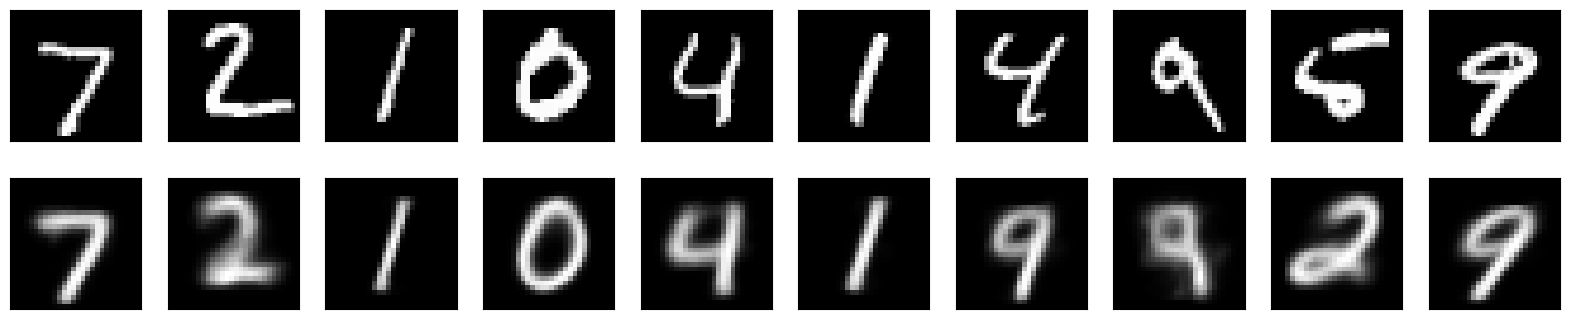

In [ ]:
# Visualize the results
img = img.view(img.size(0), 1, 28, 28).to(device)
output = output.view(output.size(0), 1, 28, 28)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# This model needs to train for longer. Training for longer with the lr that gave best result
lr_range = [0.001]
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=50,verbose=False)

# # Save the trained model
# torch.save(model.state_dict(), './models/model_AE.pt')

Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
n. of epochs: 50
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.1704. Test loss: 0.1693. Time: 13.8130
 EPOCH 4. Progress: 8.0%. 
 Train loss: 0.1484. Test loss: 0.1489. Time: 13.7903
 EPOCH 8. Progress: 16.0%. 
 Train loss: 0.1411. Test loss: 0.1419. Time: 13.8155
 EPOCH 12. Progress: 24.0%. 
 Train loss: 0.1401. Test loss: 0.1414. Time: 13.8867
 EPOCH 16. Progress: 32.0%. 
 Train loss: 0.1396. Test loss: 0.1405. Time: 13.7891
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.1389. Test loss: 0.1400. Time: 13.8291
 EPOCH 24. Progress: 48.0%. 
 Train loss: 0.1390. Test loss: 0.1406. Time: 13.8344
 EPOCH 28. Progress: 56.00000000000001%. 
 Train loss: 0.1361. Test loss: 0.1370. Time: 13.7812
 EPOCH 32. Progress: 64.0%. 
 Train loss: 0.1354. Test loss: 0.1368. Time: 13.8445
 EPOCH 36. Pro

In [ ]:
# Save the trained model
torch.save(model.state_dict(), './models/model_AE_2024.pt')

In [ ]:
# Load the model
model_AE = Autoencoder().to(device)
model_AE.load_state_dict(torch.load('./models/model_AE_2024.pt',map_location=torch.device(device)))

<All keys matched successfully>

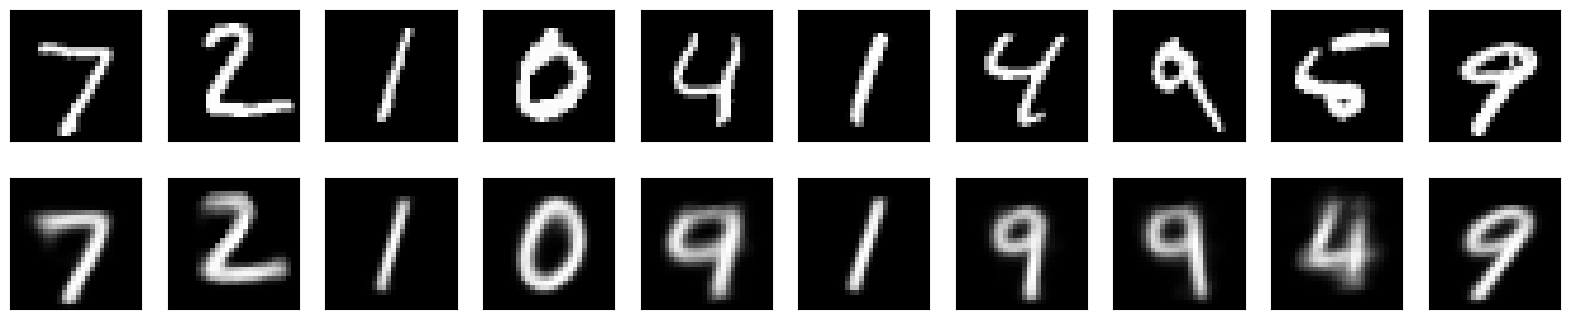

In [ ]:
# Test the model
model_AE.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(-1, 28 * 28).to(device)
        output,_ = model_AE(img)
        # Use only the first batch for visualization
        break
# Visualize the results
img = img.view(img.size(0), 1, 28, 28).to(device)
output = output.view(output.size(0), 1, 28, 28)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])


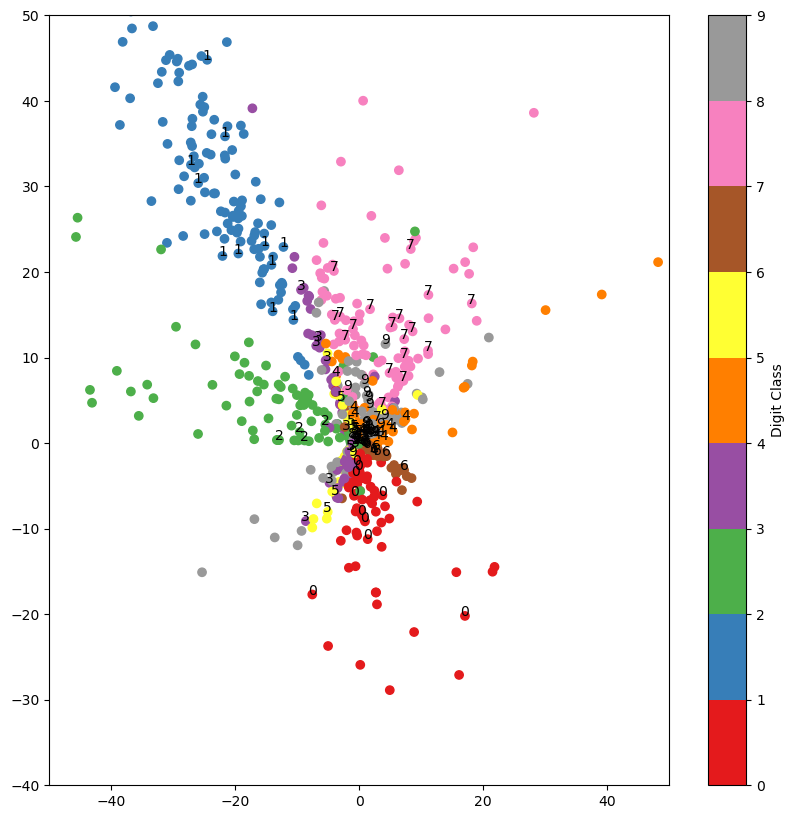

In [ ]:
## Plot the embedding of 1000 digits
# Test
large_batch = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1000,
                                          shuffle=False)

with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    scatter = plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:],cmap='Set1')

    colorbar = plt.colorbar(scatter, ticks=range(10))
    colorbar.set_label('Digit Class')

    n_points=128
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.xlim([-50,50])
    plt.ylim([-40,50])



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)

        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 784)

        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = self.tanh(x)
        # ... additional layers, plus possible nonlinearities.
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [ ]:
# This model needs to train for longer. Training for longer with the lr that gave best result
lr_range = [0.001]
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=50,verbose=False)

# # Save the trained model
# torch.save(model.state_dict(), './models/model_AE.pt')

Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
n. of epochs: 50
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.2015. Test loss: 0.2003. Time: 13.8620
 EPOCH 4. Progress: 8.0%. 
 Train loss: 0.1583. Test loss: 0.1586. Time: 13.8024
 EPOCH 8. Progress: 16.0%. 
 Train loss: 0.1571. Test loss: 0.1571. Time: 13.9614
 EPOCH 12. Progress: 24.0%. 
 Train loss: 0.1509. Test loss: 0.1509. Time: 14.0840
 EPOCH 16. Progress: 32.0%. 
 Train loss: 0.1490. Test loss: 0.1496. Time: 13.8092
 EPOCH 20. Progress: 40.0%. 
 Train loss: 0.1499. Test loss: 0.1502. Time: 13.8824
 EPOCH 24. Progress: 48.0%. 
 Train loss: 0.1520. Test loss: 0.1530. Time: 13.8401


In [ ]:
# # Save the trained model
# torch.save(model.state_dict(), './models/model_AE_2024_v2.pt')
# Load the model
model_AE = Autoencoder().to(device)
model_AE.load_state_dict(torch.load('./models/model_AE_2024_v2.pt',map_location=torch.device(device)))

<All keys matched successfully>

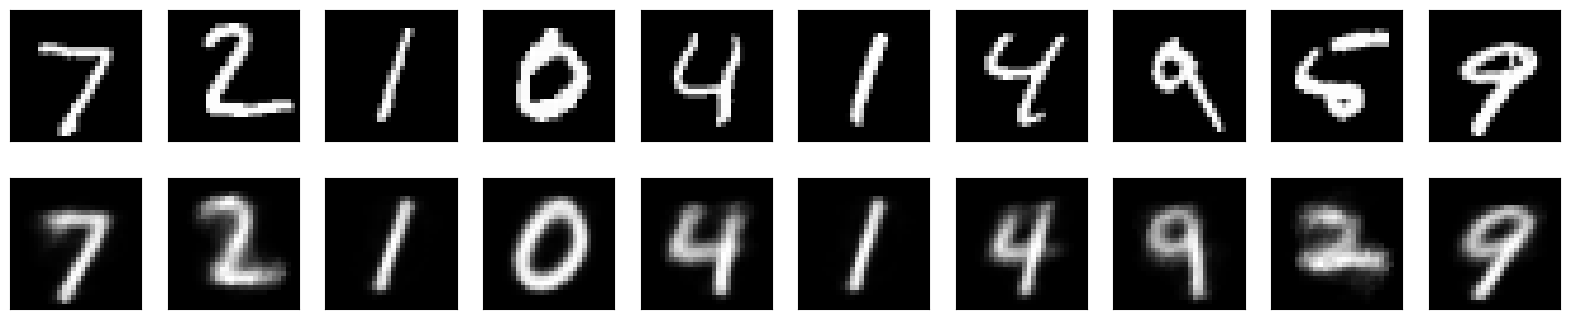

In [ ]:
# Test the model
model_AE.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(-1, 28 * 28).to(device)
        output,_ = model_AE(img)
        # Use only the first batch for visualization
        break
# Visualize the results
img = img.view(img.size(0), 1, 28, 28).to(device)
output = output.view(output.size(0), 1, 28, 28)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])


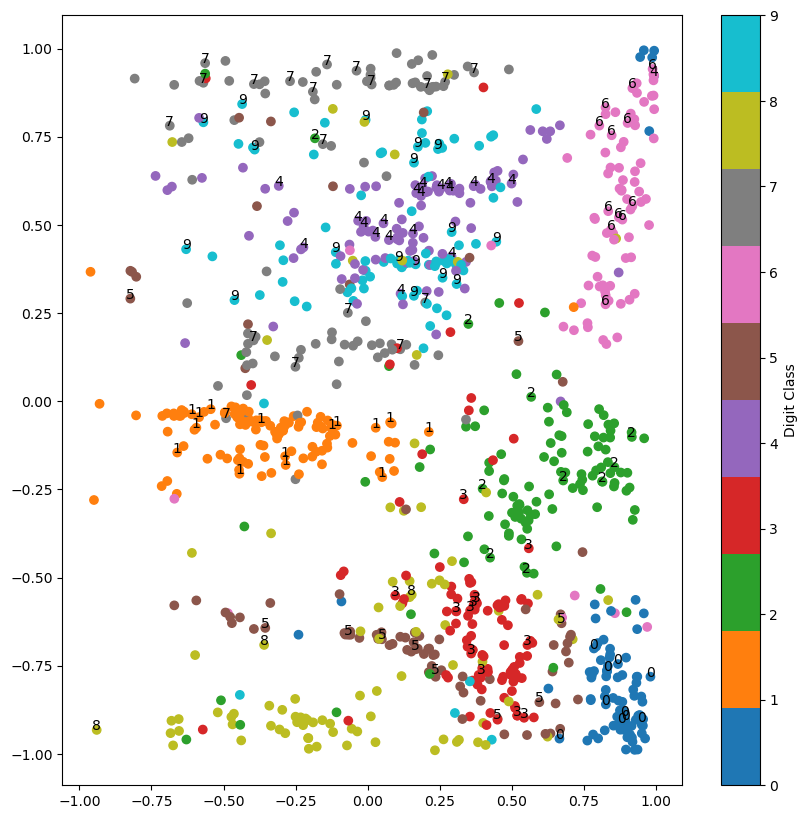

In [ ]:
## Plot the embedding of 1000 digits
# Test
large_batch = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1000,
                                          shuffle=False)

with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    scatter = plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:],cmap='tab10')

    colorbar = plt.colorbar(scatter, ticks=range(10))
    colorbar.set_label('Digit Class')

    n_points=128
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    # plt.xlim([-50,50])
    # plt.ylim([-40,50])


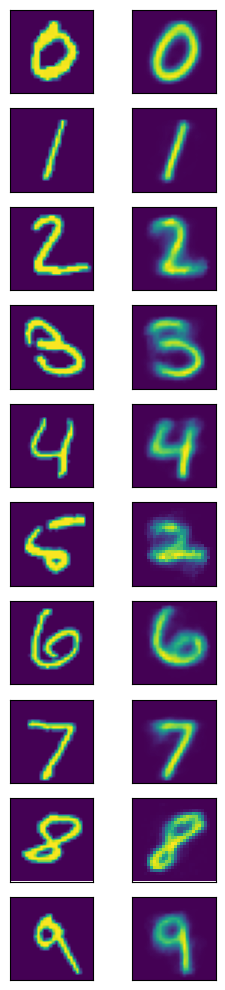

In [ ]:
with torch.no_grad():
    data, targets = next(iter(large_batch))
    model_input = data.view(data.size(0),-1).to(device)
    out, latentVar = model_AE(model_input)
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    model_input = model_input.cpu().numpy()
    out = out.cpu().numpy()

    fig,ax = plt.subplots(10,2,figsize=(3,10))
    ax = ax.ravel()
    count=0
    for idx1 in range(10):
        for idx2 in range(len(targets)): #Looking for the digit among the labels
            if idx1==targets[idx2]:
                ax[count].imshow(model_input[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                ax[count].imshow(out[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                break

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
targets[:20]: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
latentVar[:20]: [[-0.2692261   0.9075825 ]
 [ 0.3990975  -0.2480253 ]
 [-0.6104319  -0.03676655]
 [ 0.868582   -0.74508035]
 [ 0.27797762  0.6069176 ]
 [-0.58470863 -0.04494355]
 [-0.01409084  0.49578038]
 [ 0.30872434  0.33243328]
 [ 0.52330464  0.17065628]
 [-0.3920374   0.71362823]
 [ 0.89069986 -0.89262277]
 [ 0.9185639   0.88778454]
 [-0.00698306  0.7978916 ]
 [ 0.8265884  -0.85943294]
 [-0.28420523 -0.18062441]
 [ 0.595865   -0.85329926]
 [ 0.160896    0.6764754 ]
 [-0.03846204  0.9373556 ]
 [ 0.5428598  -0.8975482 ]
 [ 0.15730484  0.47557408]]
x0,y0: -0.2692261040210724,0.9075825214385986
x1,y1: 0.3990975022315979,-0.2480252981185913
xvals: [-0.2692261  -0.19496793 -0.12070975 -0.04645157  0.02780661  0.10206479
  0.17632297  0.25058115  0.32483932  0.3990975 ]
yvals: [ 0.90758252  0.77918165  0.65078078  0.522

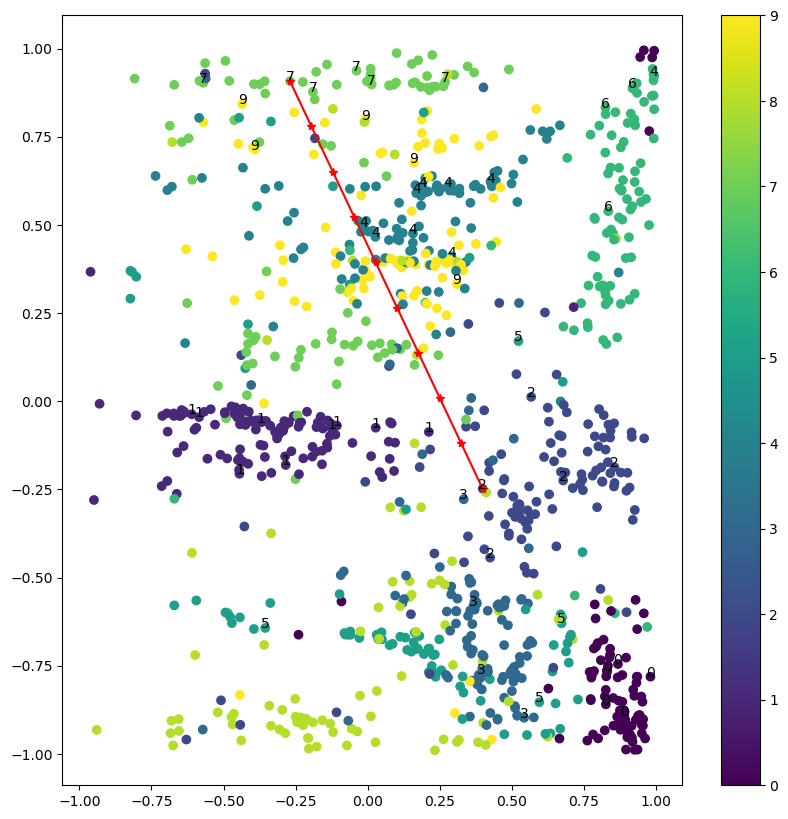

In [ ]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')


model_input: tensor([-0.2692,  0.9076])
model_input: tensor([-0.1950,  0.7792])
model_input: tensor([-0.1207,  0.6508])
model_input: tensor([-0.0465,  0.5224])
model_input: tensor([0.0278, 0.3940])
model_input: tensor([0.1021, 0.2656])
model_input: tensor([0.1763, 0.1372])
model_input: tensor([0.2506, 0.0088])
model_input: tensor([ 0.3248, -0.1196])
model_input: tensor([ 0.3991, -0.2480])


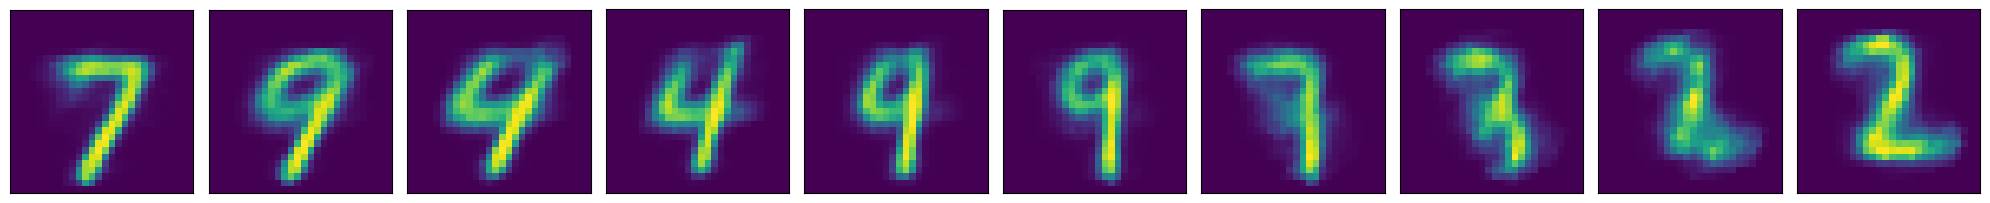

In [ ]:
# Decode the interpolated points across classes
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))

        out = model_AE.decode(model_input.to(device))
        out = out.cpu().numpy()

        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
[11 21]
targets[:20]: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
latentVar[:20]: [[-0.2692261   0.9075825 ]
 [ 0.3990975  -0.2480253 ]
 [-0.6104319  -0.03676655]
 [ 0.868582   -0.74508035]
 [ 0.27797762  0.6069176 ]
 [-0.58470863 -0.04494355]
 [-0.01409084  0.49578038]
 [ 0.30872434  0.33243328]
 [ 0.52330464  0.17065628]
 [-0.3920374   0.71362823]
 [ 0.89069986 -0.89262277]
 [ 0.9185639   0.88778454]
 [-0.00698306  0.7978916 ]
 [ 0.8265884  -0.85943294]
 [-0.28420523 -0.18062441]
 [ 0.595865   -0.85329926]
 [ 0.160896    0.6764754 ]
 [-0.03846204  0.9373556 ]
 [ 0.5428598  -0.8975482 ]
 [ 0.15730484  0.47557408]]
x0,y0: 0.9185639023780823,0.8877845406532288
x1,y1: 0.8348444700241089,0.5390298366546631
xvals: [0.9185639  0.90926174 0.89995958 0.89065742 0.88135527 0.87205311
 0.86275095 0.85344879 0.84414663 0.83484447]
yvals: [0.88778454 0.84903402 0.8102835  0.77153297 0.

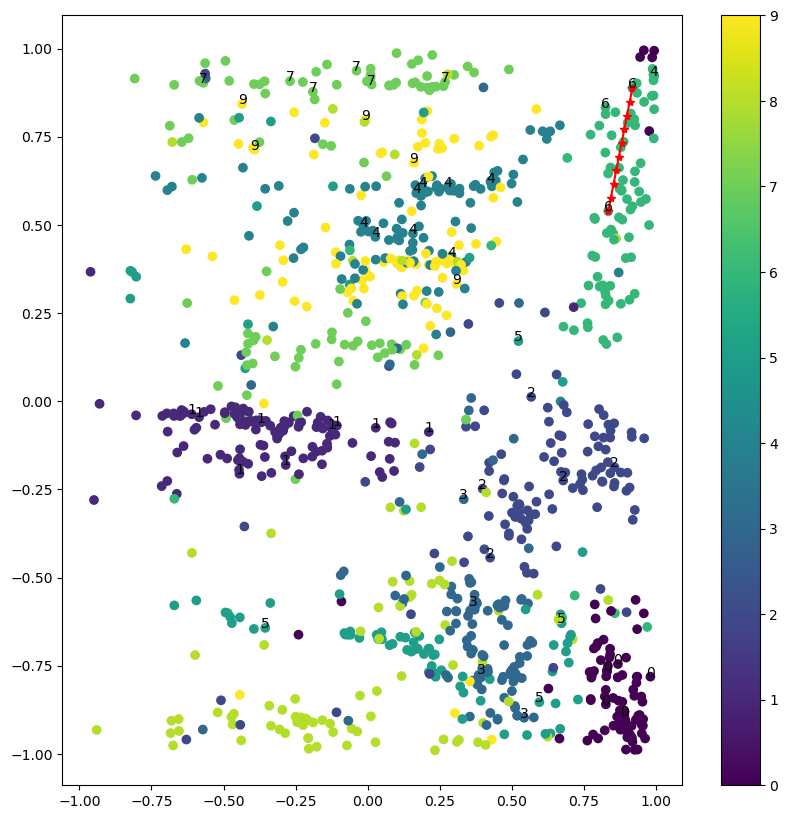

In [ ]:
# Interpolate between two images of the same class
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    idx_ = np.where(targets==6)[0] # Get two '6'.
    print(idx_[:2])

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')


model_input: tensor([0.9186, 0.8878])
model_input: tensor([0.9093, 0.8490])
model_input: tensor([0.9000, 0.8103])
model_input: tensor([0.8907, 0.7715])
model_input: tensor([0.8814, 0.7328])
model_input: tensor([0.8721, 0.6940])
model_input: tensor([0.8628, 0.6553])
model_input: tensor([0.8534, 0.6165])
model_input: tensor([0.8441, 0.5778])
model_input: tensor([0.8348, 0.5390])


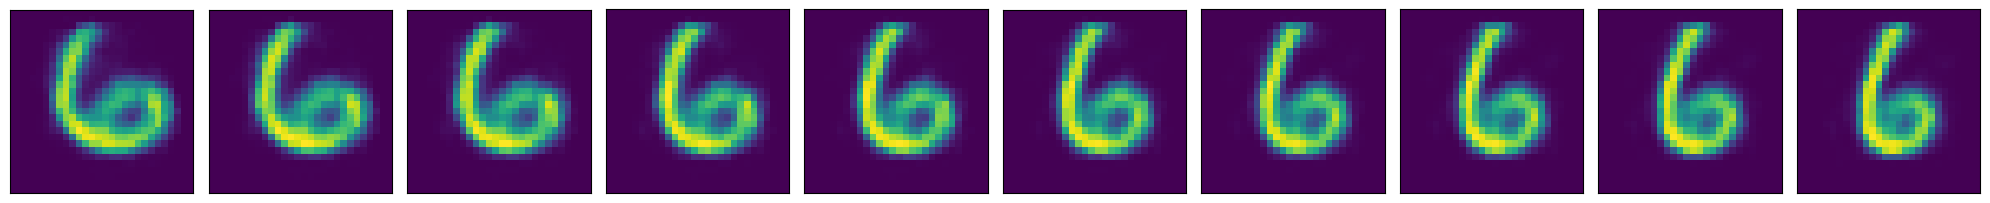

In [ ]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        # model = AE_decoder()

        out = model_AE.decode(model_input.to(device))
        out = out.cpu().numpy()

        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

## Question 1.1.
__Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?__

## Question 1.2.
__How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?__

# Section 2

Now that we have an autoencoder working on MNIST, let's use this model to visualize some geodata. For the next section we will use the SAT-6 (https://csc.lsu.edu/~saikat/deepsat/)

SAT-6 consists of a total of 405,000 image patches each of size 28x28 and covering <span style="color:red"> 6 landcover classes - barren land, trees, grassland, roads, buildings and water bodies</span>. 324,000 images (comprising of four-fifths of the total dataset) were chosen as the training dataset and 81,000 (one fifths) were chosen as the testing dataset. Similar to SAT-4, the training and test sets were selected from disjoint NAIP tiles. Once generated, the images in the dataset were randomized in the same way as that for SAT-4. The specifications for the various landcover classes of SAT-4 and SAT-6 were adopted from those used in the National Land Cover Data (NLCD) algorithm.

The datasets are encoded as MATLAB .mat files that can be read using the standard load command in MATLAB.  <span style="color:red">Each sample image is 28x28 pixels and consists of 4 bands - red, green, blue and near infrared </span>. The training and test labels are 1x4 and 1x6 vectors for SAT-4 and SAT-6 respectively having a single 1 indexing a particular class from 0 through 4 or 6 and 0 values at all other indices.

The MAT file for the SAT-6 dataset contains the following variables:

- train_x	28x28x4x324000 uint8 (containing 324000 training samples of 28x28 images each with 4 channels)
- train_y	324000x6 uint8 (containing 6x1 vectors having labels for the 324000 training samples)
- test_x	28x28x4x81000 uint8 (containing 81000 test samples of 28x28 images each with 4 channels)
- test_y	81000x6 uint8 (containing 6x1 vectors having labels for the 81000 test samples)

Labels:
- Building = 0
- Barren_land = 1
- Tree=2
- Grassland=3
- Road = 4
- Water = 5

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
from torch import optim, nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Using the satelite images dataset
###############################################################################
#load the data
data = scipy.io.loadmat("./SAT-4_and_SAT-6_datasets/sat-6-full.mat")
train_images = data['train_x']
train_labels = data['train_y']

test_images = data['test_x']
test_labels = data['test_y']

In [ ]:
####################################################################
#Checkout the data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (28, 28, 4, 324000) (6, 324000)
Testing data shape :  (28, 28, 4, 81000) (6, 81000)


In [ ]:
#Change the dimension to fit into the model
x_train = train_images.transpose(3,0,1,2)
t_train = train_labels.transpose()

# x_test = test_images.transpose(3,0,1,2)
# t_test = test_labels.transpose()
print('Training data shape : ', x_train.shape, t_train.shape)
print(f'Range of the dataset: min: {x_train.min()}, max: {x_train.max()}')
# print('Testing data shape : ', x_test.shape, t_test.shape)

Training data shape :  (324000, 28, 28, 4) (324000, 6)
Range of the dataset: min: 0, max: 255


count, t_train[count,:]: 0, [0 0 1 0 0 0]
count, t_train[count,:]: 1, [0 1 0 0 0 0]
count, t_train[count,:]: 2, [0 0 0 0 0 1]
count, t_train[count,:]: 3, [0 0 0 0 0 1]
count, t_train[count,:]: 4, [0 0 0 0 0 1]
count, t_train[count,:]: 5, [1 0 0 0 0 0]
count, t_train[count,:]: 6, [1 0 0 0 0 0]
count, t_train[count,:]: 7, [0 0 0 0 0 1]
count, t_train[count,:]: 8, [0 1 0 0 0 0]
count, t_train[count,:]: 9, [0 0 1 0 0 0]
count, t_train[count,:]: 10, [0 0 0 0 0 1]
count, t_train[count,:]: 11, [0 1 0 0 0 0]
count, t_train[count,:]: 12, [0 1 0 0 0 0]
count, t_train[count,:]: 13, [0 0 0 0 1 0]
count, t_train[count,:]: 14, [0 0 0 0 0 1]
count, t_train[count,:]: 15, [0 0 1 0 0 0]


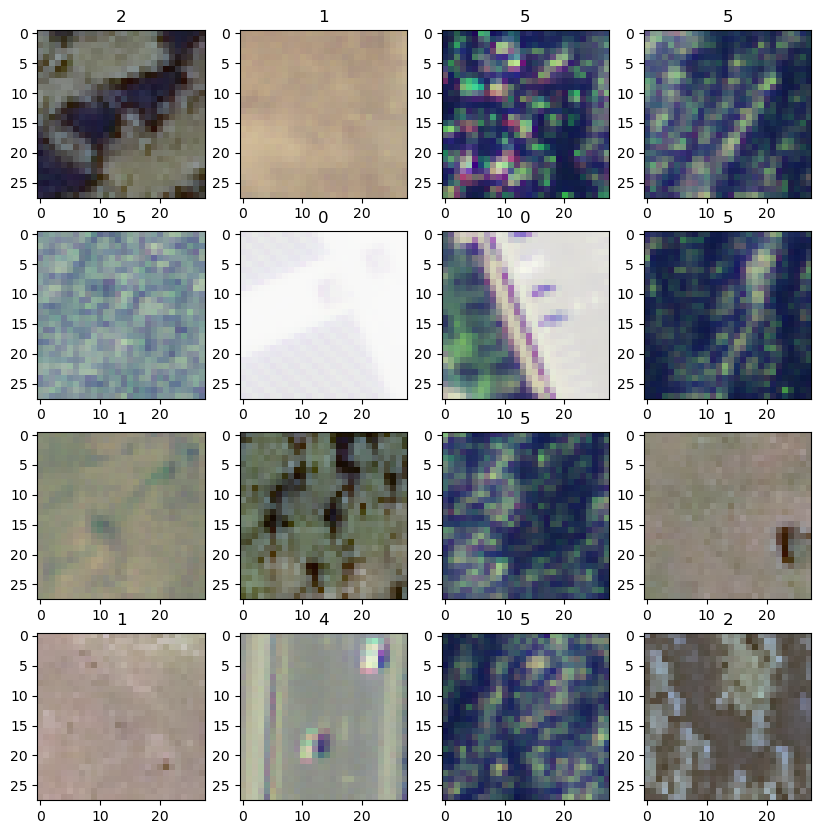

In [ ]:
#Check what is in each channel
fig,ax = plt.subplots(4,4, figsize=(10,10))
ax = ax.ravel()
list_idx = np.linspace(0,100,num=16,dtype=np.int64)
for count, idx in enumerate(list_idx):
#     print(idx)
    print('count, t_train[count,:]: {}, {}'.format(count, t_train[count,:]))
#     print(x_train[idx,:,:,0:3])
    ax[count].imshow(x_train[count,:,:,0:3])
    ax[count].set_title(str(np.argmax(t_train[count,:])))

In [ ]:
# split in training and testing
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from scipy.ndimage import zoom


class MyDataset(Dataset):
    def __init__(self, data, target):
        print('data.dtype: {}'.format(data.dtype))
        print('target.dtype: {}'.format(target.dtype))
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()


    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

print('x_train.shape: {}'.format(x_train.shape))
n_samples = 50000
dataset = MyDataset(x_train[:n_samples,:,:,:], np.argmax(t_train[:n_samples],axis=1))
del x_train, t_train
dataset_size  = len(dataset)
print('dataset_size: {}'.format(dataset_size))
test_split=0.2

# Number of frames in the sequence (in this case, same as number of tokens). Maybe I can make this number much bigger, like 4 times bigger, and then do the batches of batches...
# For example, when classifying, I can test if the first and the second chunk are sequence vs the first and third
batch_size=1024 #Originally 16 frames... can I do 128 and then split in 4 chunks of 32

# -- split dataset
indices       = list(range(dataset_size))
split         = int(np.floor(test_split*dataset_size))
print('split: {}'.format(split))
# np.random.shuffle(indices) # Randomizing the indices is not a good idea if you want to model the sequence
train_indices, val_indices = indices[split:], indices[:split]

# -- create dataloaders
# #Original
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders   = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6, sampler=valid_sampler),
    'all': torch.utils.data.DataLoader(dataset,  batch_size=5000, num_workers=6, shuffle=False),
    }

/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


x_train.shape: (324000, 28, 28, 4)
data.dtype: uint8
target.dtype: int64
dataset_size: 50000
split: 10000


/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class Autoencoder(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function)
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(3136, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)

        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 3136)

        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = self.tanh(x)
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        # x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [ ]:
lr_range = [0.001]#0.01,0.005,
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],verbose=False)

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
n. of epochs: 20
 EPOCH 0. Progress: 0.0%. 
 Train loss: 8487.9573. Test loss: 8455.3874. Time: 17.4745
 EPOCH 4. Progress: 20.0%. 
 Train loss: 3125.1157. Test loss: 3151.3001. Time: 17.9160
 EPOCH 8. Progress: 40.0%. 
 Train loss: 3120.1654. Test loss: 3141.1976. Time: 17.8938
 EPOCH 12. Progress: 60.0%. 
 Train loss: 3119.4537. Test loss: 3141.9491. Time: 17.6789
 EPOCH 16. Progress: 80.0%. 
 Train loss: 3129.6639. Test loss: 3145.4181. Time: 17.7742
 EPOCH 20. Progress: 100.0%. 
 Train loss: 3129.7260. Test loss: 3142.8313. Time: 18.2444


In [ ]:
# #Save this model
# torch.save(model.state_dict(), './models/model_AE_sat6.pt')
# # Load the model
# model = Autoencoder().to(device)
# model.load_state_dict(torch.load('./models/model_AE_sat6.pt',map_location=torch.device(device)))

<All keys matched successfully>

targets.shape: torch.Size([5000])
np.unique(targets): [0. 1. 2. 3. 4. 5.]
latentVar.shape: torch.Size([5000, 2])
targets[:20]: [2. 1. 5. 5. 5. 0. 0. 5. 1. 2. 5. 1. 1. 4. 5. 2. 5. 3. 3. 1.]
latentVar[:20]: [[-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]
 [-0.99709165 -0.99962926]
 [-0.99709165 -0.99962926]
 [-0.99709165 -0.99962926]
 [-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]
 [-0.99709165 -0.99962926]
 [-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]
 [-0.99709165 -0.99962926]
 [-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]
 [-0.99709165 -0.99962926]
 [-0.9970782  -0.9996315 ]
 [-0.99709165 -0.99962926]
 [-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]
 [-0.9970782  -0.9996315 ]]


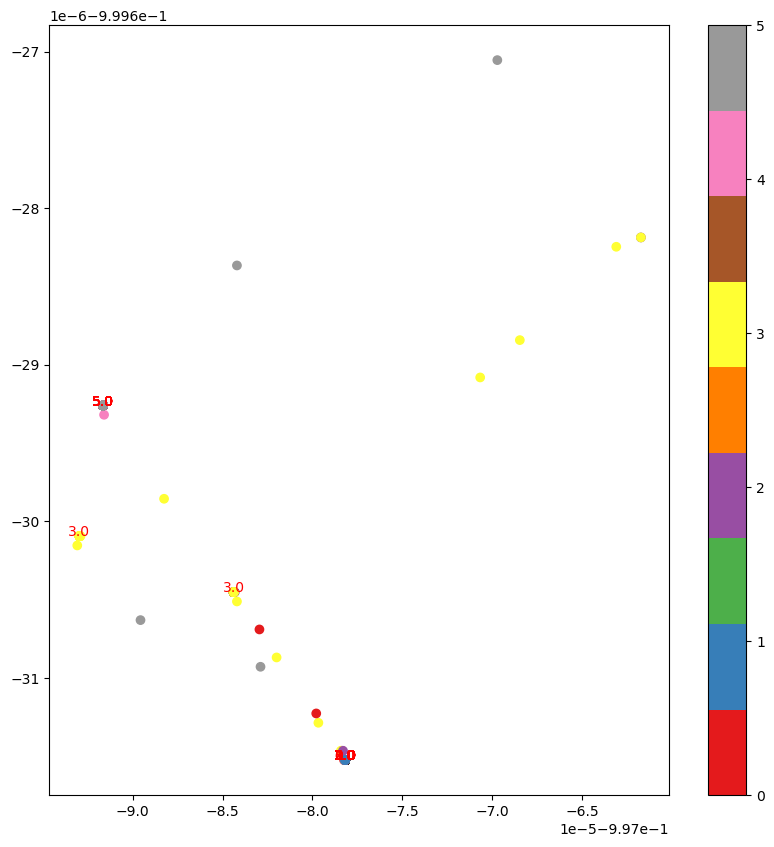

In [ ]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(dataloaders['all']))

    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model(model_input)
    del out, model_input
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:],cmap='Set1')
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

In [ ]:
class Autoencoder(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function and relus)
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(3136, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)

        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 3136)

#         self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.relu(x)
        x = self.enc_lin2(x)
        x = self.relu(x)
        x = self.enc_lin3(x)
        x = self.relu(x)
        x = self.enc_lin4(x)
        z = x
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.relu(x)
        x = self.dec_lin2(x)
        x = self.relu(x)
        x = self.dec_lin3(x)
        x = self.relu(x)
        x = self.dec_lin4(x)
        x = self.relu(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [ ]:
lr_range = [0.001]#, 0.0005]
# for hid_dim in hid_dim_range:
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],num_epochs=50,verbose=False)

Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
n. of epochs: 50
 EPOCH 0. Progress: 0.0%. 
 Train loss: 3185.0341. Test loss: 3183.5599. Time: 18.8018
 EPOCH 4. Progress: 8.0%. 
 Train loss: 2916.5854. Test loss: 2917.7543. Time: 17.7644
 EPOCH 8. Progress: 16.0%. 
 Train loss: 2913.7350. Test loss: 2916.6664. Time: 18.8433
 EPOCH 12. Progress: 24.0%. 
 Train loss: 2913.7227. Test loss: 2917.1346. Time: 17.6287
 EPOCH 16. Progress: 32.0%. 
 Train loss: 1435.1767. Test loss: 1435.9584. Time: 17.8440
 EPOCH 20. Progress: 40.0%. 
 Train loss: 1407.3472. Test loss: 1403.9744. Time: 17.7386
 EPOCH 24. Progress: 48.0%. 
 Train loss: 1381.8580. Test loss: 1382.9462. Time: 17.7674
 EPOCH 28. Progress: 56.00000000000001%. 
 Train loss: 1359.4133. Test loss: 1360.5870. Time: 18.6433
 EPOCH 32. Progress: 64.0%. 
 Train loss: 1308.71

In [ ]:
#Save this model
torch.save(model.state_dict(), './models/model_AE_sat6_v2.pt')
# Load the model
model = Autoencoder().to(device)
model.load_state_dict(torch.load('./models/model_AE_sat6_v2.pt',map_location=torch.device(device)))

<All keys matched successfully>

targets.shape: torch.Size([5000])
np.unique(targets): [0. 1. 2. 3. 4. 5.]
latentVar.shape: torch.Size([5000, 2])
targets[:20]: [2. 1. 5. 5. 5. 0. 0. 5. 1. 2. 5. 1. 1. 4. 5. 2. 5. 3. 3. 1.]
latentVar[:20]: [[-3.2174875e+02  3.4239325e+02]
 [-6.1856006e+02  5.5036823e+02]
 [-2.5499382e+02  4.2290009e+01]
 [-2.6465213e+02  5.4591499e+01]
 [-4.5327759e+02  6.5481270e+01]
 [-8.7976367e+02  6.1360492e+02]
 [-6.1683478e+02  3.9894885e+02]
 [-1.9657349e+02  1.2717419e+01]
 [-5.1967316e+02  5.1280316e+02]
 [-3.7088477e+02  5.3241010e+02]
 [-2.5197504e+02  5.2278961e+01]
 [-5.0760413e+02  5.2265826e+02]
 [-6.0273376e+02  5.5638153e+02]
 [-5.3306921e+02  2.9994623e+02]
 [-2.3863507e+02  6.1348915e-02]
 [-4.0140491e+02  4.5150562e+02]
 [-2.8270001e+02  2.8084137e+01]
 [-4.6931290e+02  5.4682269e+02]
 [-4.2842490e+02  5.8886017e+02]
 [-5.8722314e+02  5.1664325e+02]]


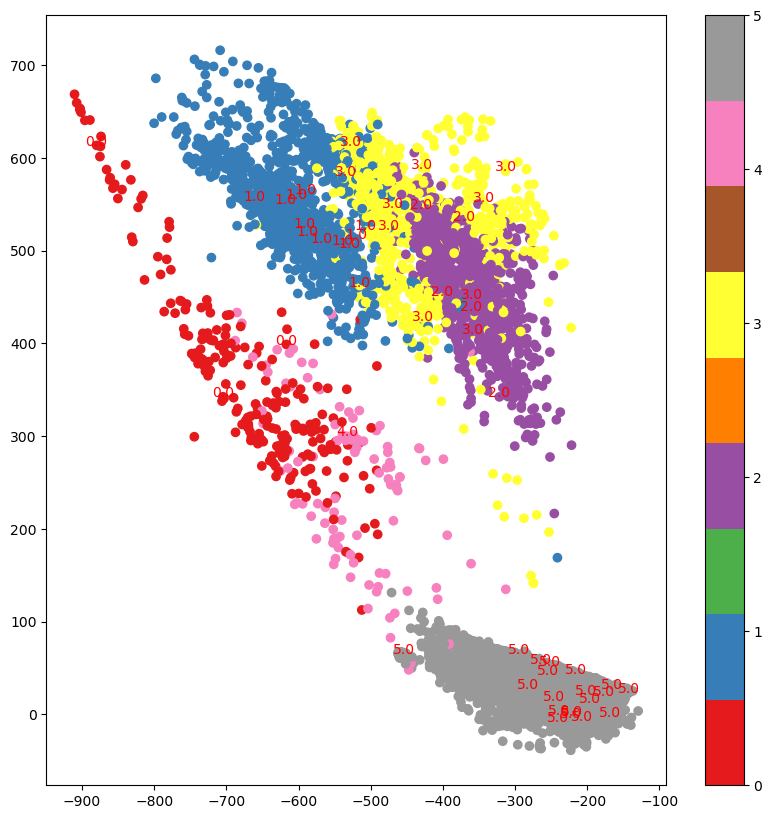

In [ ]:
# Interpolate between two images of different classes
with torch.no_grad():
    plt.close('all')
    data, targets = next(iter(dataloaders['all']))

    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model(model_input)
    del out, model_input
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:],cmap='Set1')
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

targets.shape: torch.Size([5000])
np.unique(targets): [0. 1. 2. 3. 4. 5.]
latentVar.shape: torch.Size([5000, 2])
[1 8]
targets[:20]: [2. 1. 5. 5. 5. 0. 0. 5. 1. 2. 5. 1. 1. 4. 5. 2. 5. 3. 3. 1.]
latentVar[:20]: [[-3.2174875e+02  3.4239325e+02]
 [-6.1856006e+02  5.5036823e+02]
 [-2.5499382e+02  4.2290009e+01]
 [-2.6465213e+02  5.4591499e+01]
 [-4.5327759e+02  6.5481270e+01]
 [-8.7976367e+02  6.1360492e+02]
 [-6.1683478e+02  3.9894885e+02]
 [-1.9657349e+02  1.2717419e+01]
 [-5.1967316e+02  5.1280316e+02]
 [-3.7088477e+02  5.3241010e+02]
 [-2.5197504e+02  5.2278961e+01]
 [-5.0760413e+02  5.2265826e+02]
 [-6.0273376e+02  5.5638153e+02]
 [-5.3306921e+02  2.9994623e+02]
 [-2.3863507e+02  6.1348915e-02]
 [-4.0140491e+02  4.5150562e+02]
 [-2.8270001e+02  2.8084137e+01]
 [-4.6931290e+02  5.4682269e+02]
 [-4.2842490e+02  5.8886017e+02]
 [-5.8722314e+02  5.1664325e+02]]
x0,y0: -618.56005859375,550.3682250976562
x1,y1: -519.6731567382812,512.8031616210938
xvals: [-618.56005859 -607.57262505 -596.5

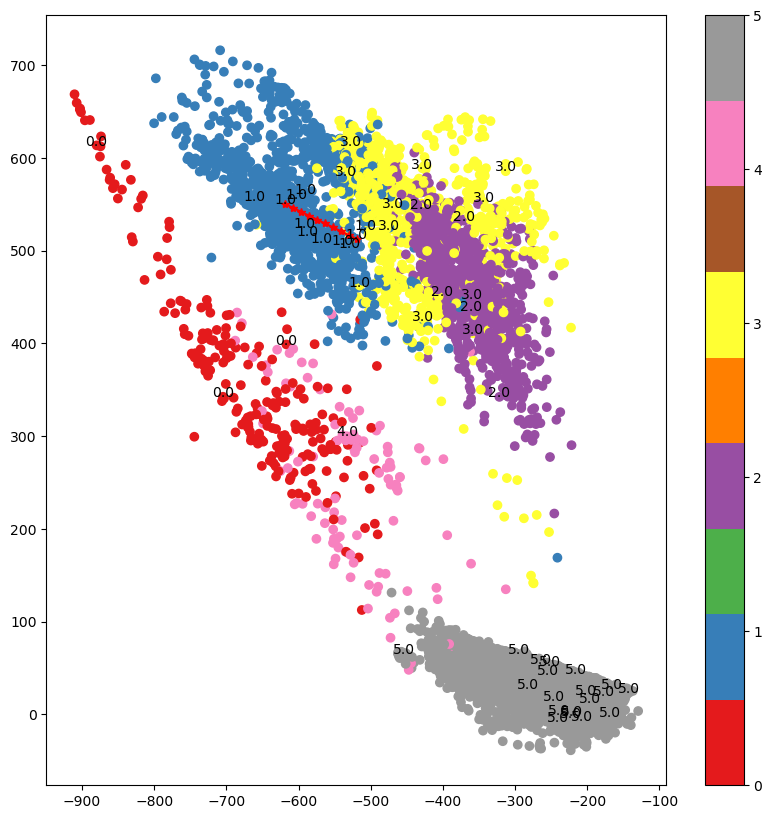

In [ ]:
# Interpolate between two images of the same class
with torch.no_grad():
    plt.close('all')
    data, targets = next(iter(dataloaders['all']))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    idx_ = np.where(targets==1)[0] # Get two '6'.
    print(idx_[:2])

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:],cmap='Set1')
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(6))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')


model_input: tensor([-618.5601,  550.3682])
(3136,)
(28, 28, 3)
0.0
183.64345
model_input: tensor([-607.5726,  546.1943])
(3136,)
(28, 28, 3)
0.0
181.94843
model_input: tensor([-596.5852,  542.0204])
(3136,)
(28, 28, 3)
0.0
180.25423
model_input: tensor([-585.5978,  537.8466])
(3136,)
(28, 28, 3)
0.0
178.55399
model_input: tensor([-574.6104,  533.6727])
(3136,)
(28, 28, 3)
0.0
176.77863
model_input: tensor([-563.6229,  529.4987])
(3136,)
(28, 28, 3)
0.0
175.0097
model_input: tensor([-552.6354,  525.3248])
(3136,)
(28, 28, 3)
0.0
173.25687
model_input: tensor([-541.6480,  521.1509])
(3136,)
(28, 28, 3)
0.0
171.31386
model_input: tensor([-530.6606,  516.9771])
(3136,)
(28, 28, 3)
0.0
169.34329
model_input: tensor([-519.6732,  512.8032])
(3136,)
(28, 28, 3)
0.0
167.42819


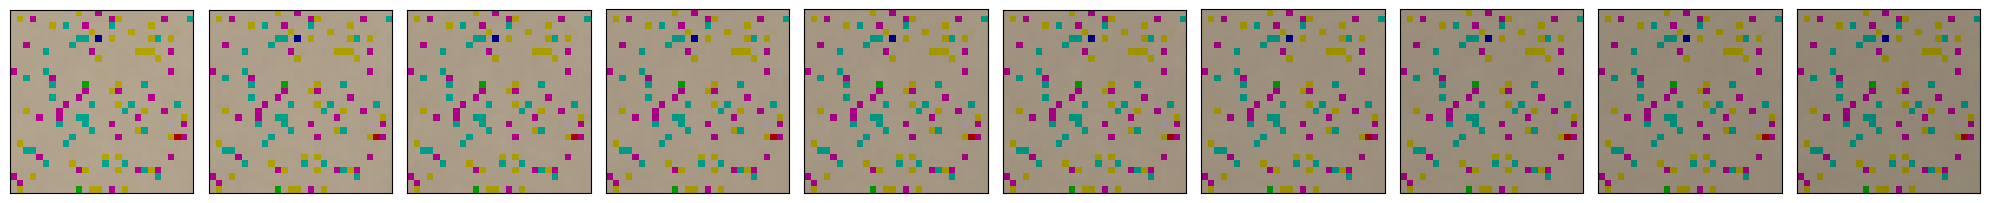

In [ ]:
with torch.no_grad():
    plt.close('all')
    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        # model = AE_decoder()

        out = model.decode(model_input.to(device))
        out = out.cpu().numpy()
        print(out.shape)
        print(out.reshape(4,28,28)[:3,:,:].transpose(1,2,0).shape)
        print(out.reshape(4,28,28)[:3,:,:].transpose(1,2,0).min())
        print(out.reshape(4,28,28)[:3,:,:].transpose(1,2,0).max())
        # ax[count].imshow(out.reshape(4,28,28)[:3,:,:].transpose(1,2,0).astype(np.uint8)) #ax[count].imshow(x_train[count,:,:,0:3])
        ax[count].imshow(out.reshape(28,28,4)[:,:,:3].astype(np.uint8)) #ax[count].imshow(x_train[count,:,:,0:3])
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

## Question 2.1.
__How many clusters are visible in the embedding? Do they correspond to the cluster labels?__

# Section 3 - Generative Models

Now, let's try something more interesting: generating data. In this section, you'll implement a variation of the autoencoder (called a "Variational Autoencoder") and a Generative Adversiarial Network, and will employ both to create never-before seen handwritten digits.

## Section 3.1 - Variational Autoencoder

Autoencoders are great, but their latent spaces can be messy. You may have noticed previously that the AE's embedding of MNIST clumped each digit into separate islands, with some overlap but also large empty regions. As you saw, the points in these empty parts of the embedding don't correspond well to real digits.


This is the founding idea of the Variational Autoencoder, which makes two modifications to make interpolation within the latent space more meaningful. The first modification is the strangest: instead of encoding points in a latent space, the encoder creates a gaussian probability distribution around the encoded point, with a mean and squared variance unique to each point. The decoder is then passed a random sample from this distribution. This encourages similar points in the latent space to correspond to similar outputs, since the decoder only gets to choose a point close to the encoded original.


If the first of these regularizations encourages similar latent representations within clusters, the second enforces proximity between clusters. This is achieved with the Kullback Leibler (KL) divergence, which tabulates the dissimilarity of the previously generated gaussian with a standard normal distribution; measuring, in effect, how much the varaince and mean differ from a variance of one and mean of zero. This prevents any class of embeddings from drifting too far away from the others. The KL divergence between two normal distributions is given by:

$D_{KL}[N(\mu,\sigma)||N(0,1)] = (1/2)\sum{1 + log\sigma^2-\mu^2-\sigma^2}$

where the sum is taken over each dimension in the latent space.

An excellent and highly entertaining introduction to Variational Autoencoders may be found in David Foster's book, "Generative Deep Learning". Additionally, the mathematically inclined may enjoy Kingma and Welling's 2013 paper "Auto-encoding Variational Bayes" (https://arxiv.org/pdf/1312.6114) which first presented the theoretical foundations for the Variational Autoencoder.

In [ ]:
# Loading the dataset and create dataloaders
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
# from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True, transform = transforms.ToTensor())

batch_size = 128
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

In [ ]:
'''
Ref: https://github.com/pytorch/examples/blob/master/vae/main.py
'''

import argparse
import torch
import os
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

path_to_save = './plots_VAE'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

class Args:
    batch_size = 128
    epochs = 50
    seed = 1
    no_cuda=False
    log_interval=100

args=Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu") # Use NVIDIA CUDA GPU if available

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_MSE = nn.MSELoss().to(device)

def VAE_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1,784), reduction='sum')

    # Compute the KLD
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, KLD


def train(epoch):
    model.train()
    train_loss = 0
    train_KLD=0
    train_recon_loss=0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss, KLD = VAE_loss_function(recon_batch, data, mu, logvar)
        loss = recon_loss + KLD
        loss.backward()
        train_loss += loss.item()
        train_KLD += KLD.item()
        train_recon_loss += recon_loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.6f} (Loss_recon: {:.6f}, Loss_KLD: {:.6f})'.format(
          epoch, train_loss / len(train_loader.dataset), train_recon_loss/ len(train_loader.dataset),
                train_KLD / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    test_KLD=0
    test_recon_loss=0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
#             test_loss += VAE_loss_function(recon_batch, data, mu, logvar).item()
            recon_loss, KLD = VAE_loss_function(recon_batch, data, mu, logvar)
            loss = recon_loss + KLD
            test_recon_loss += recon_loss.item()
            test_KLD += KLD.item()
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), './plots_VAE/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.6f} (Loss_recon: {:.6f}, Loss_KLD: {:.6f})\n'.format(test_loss, test_recon_loss/ len(test_loader.dataset),
                test_KLD / len(test_loader.dataset)))


In [ ]:
# if __name__ == "__main__":
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   './plots_VAE/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.513916
Train Epoch: 1 [12800/60000 (21%)]	Loss: 264.934357
Train Epoch: 1 [25600/60000 (43%)]	Loss: 238.307526
Train Epoch: 1 [38400/60000 (64%)]	Loss: 215.583649
Train Epoch: 1 [51200/60000 (85%)]	Loss: 205.424362
====> Epoch: 1 Average loss: 260.042051 (Loss_recon: 243.885006, Loss_KLD: 16.157045)
====> Test set loss: 196.654672 (Loss_recon: 182.003053, Loss_KLD: 14.651619)

Train Epoch: 2 [0/60000 (0%)]	Loss: 189.901596
Train Epoch: 2 [12800/60000 (21%)]	Loss: 185.829193
Train Epoch: 2 [25600/60000 (43%)]	Loss: 175.952423
Train Epoch: 2 [38400/60000 (64%)]	Loss: 173.225418
Train Epoch: 2 [51200/60000 (85%)]	Loss: 166.841583
====> Epoch: 2 Average loss: 177.757950 (Loss_recon: 161.248841, Loss_KLD: 16.509110)
====> Test set loss: 163.568136 (Loss_recon: 145.711363, Loss_KLD: 17.856775)

Train Epoch: 3 [0/60000 (0%)]	Loss: 169.166260
Train Epoch: 3 [12800/60000 (21%)]	Loss: 160.457840
Train Epoch: 3 [25600/60000 (43%)]	Loss: 154.515289
Train Epo

In [ ]:
# # Save the model
# torch.save(model.state_dict(), './models/model_VAE.pt')

In [ ]:
# Load the model
model_VAE = VAE().to(device)
model_VAE.load_state_dict(torch.load('./models/model_VAE.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

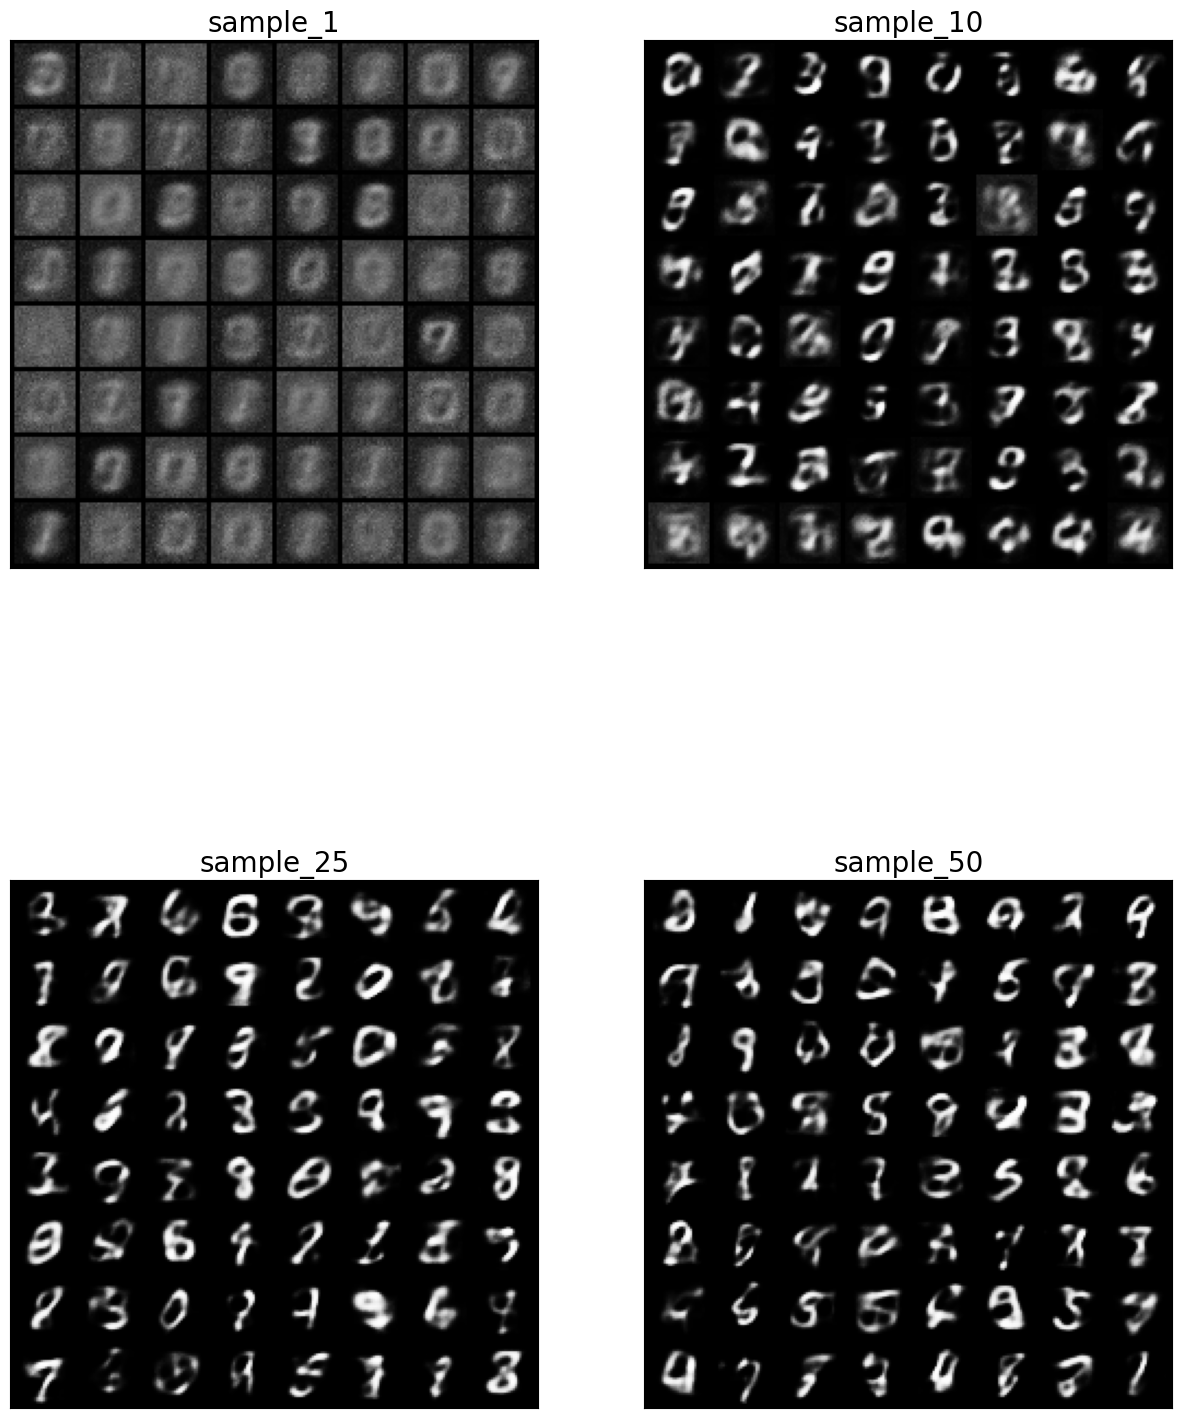

In [ ]:
# Load some of the images
from PIL import Image

fig,ax = plt.subplots(2,2,figsize=(15,20),facecolor='w')
ax = ax.ravel()
img0 = np.array(Image.open('./plots_VAE/sample_1.png'))
img10 = np.array(Image.open('./plots_VAE/sample_10.png'))
img25 = np.array(Image.open('./plots_VAE/sample_25.png'))
img50 = np.array(Image.open('./plots_VAE/sample_50.png'))
# img100 = np.array(Image.open('./plots_VAE/sample_40.png'))
# img250 = np.array(Image.open('./plots_VAE/gen_img250.png'))
# img500 = np.array(Image.open('./plots_VAE/gen_img500.png'))
# img750 = np.array(Image.open('./plots_VAE/gen_img750.png'))
# img800 = np.array(Image.open('./plots_VAE/gen_img800.png'))

ax[0].imshow(img0, cmap='gray'); #set colormap as 'gray'
ax[0].set_title("sample_1", fontsize=20);
ax[0].grid(False), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(img10, cmap='gray'); #set colormap as 'gray'
ax[1].set_title("sample_10", fontsize=20);
ax[1].grid(False), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(img25, cmap='gray'); #set colormap as 'gray'
ax[2].set_title("sample_25", fontsize=20);
ax[2].grid(False), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(img50, cmap='gray'); #set colormap as 'gray'
ax[3].set_title("sample_50", fontsize=20);
ax[3].grid(False), ax[3].set_xticks([]), ax[3].set_yticks([]);

targets[:20]: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
latentVar[:20]: [[-0.38538352  1.6870774 ]
 [-0.49421185 -1.9318627 ]
 [-2.5226293  -0.04753399]
 [ 1.9435855  -0.76406074]
 [ 1.4692234   1.4804938 ]
 [-2.8673055   0.295467  ]
 [-0.25760266  1.8064487 ]
 [ 0.28921348  0.9776171 ]
 [ 1.0407246   0.6288292 ]
 [ 0.6611991   1.0500998 ]
 [ 1.7379988  -1.1433383 ]
 [ 0.80223686 -0.56359494]
 [ 0.53450316  2.240386  ]
 [ 2.3140576  -0.21912229]
 [-2.6169264  -0.52533627]
 [-0.01252298 -0.5219928 ]
 [ 1.3504068   2.1746264 ]
 [ 0.38544187  1.4192953 ]
 [ 0.11015459 -0.06857728]
 [ 0.26654655  1.8365909 ]]
x0,y0: -0.3853835165500641,1.6870774030685425
x1,y1: -0.4942118525505066,-1.931862711906433
xvals: [-0.38538352 -0.39747555 -0.40956759 -0.42165963 -0.43375167 -0.4458437
 -0.45793574 -0.47002778 -0.48211982 -0.49421185]
yvals: [ 1.6870774   1.28497295  0.88286849  0.48076403  0.07865957 -0.32344488
 -0.72554934 -1.1276538  -1.52975825 -1.93186271]


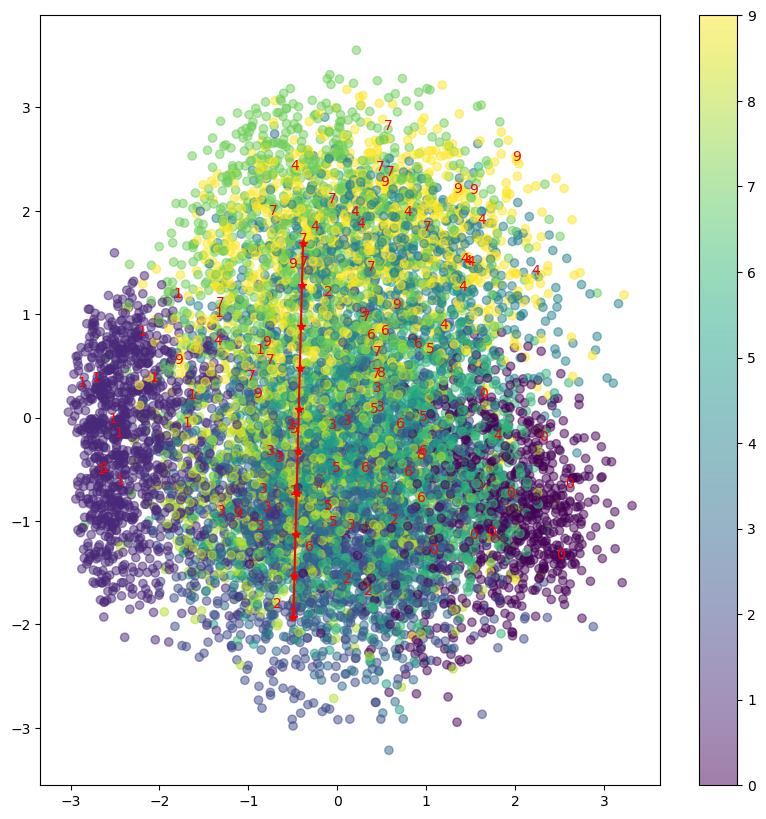

In [ ]:
# Visualize the 2D space
# Should we use PCA to embeded the 20D to 2D?
import matplotlib
from sklearn.decomposition import PCA
matplotlib.style.use('default')

large_batch = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=60000,
                                          shuffle=False)

with torch.no_grad():
    model_VAE.eval()
    data, targets = next(iter(large_batch))
    targets = targets.numpy()
    data = data.to(device)
    recon_batch, mu, logvar = model_VAE(data)

    #Reduce dimensions to 2D
    pca = PCA(n_components=2)
    latentVar = pca.fit_transform(mu.cpu().numpy())

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=100
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')

In [ ]:
print(logvar.max())
print(logvar.mean())
print(logvar.min())
print(logvar.shape)
print(mu.shape)

tensor(-0.3149, device='cuda:0')
tensor(-2.4522, device='cuda:0')
tensor(-4.6490, device='cuda:0')
torch.Size([10000, 20])
torch.Size([10000, 20])


In [ ]:
# class VAE_decoder(nn.Module):
#     def __init__(self):
#         super(VAE_decoder, self).__init__()

#         self.fc1 = model_VAE.fc1
#         self.fc21 = model_VAE.fc21
#         self.fc22 = model_VAE.fc22
#         self.fc3 = model_VAE.fc3
#         self.fc4 = model_VAE.fc4

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5*logvar)
#         eps = torch.randn_like(std)
#         return mu + eps*std

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))

#     def forward(self, mu):
# #         mu, logvar = self.encode(x.view(-1, 784))
#         logvar=torch.ones_like(mu) * -2.5
#         z = self.reparameterize(mu, logvar)
#         print('z.shape: {}'.format(z.shape))
#         return self.decode(z)


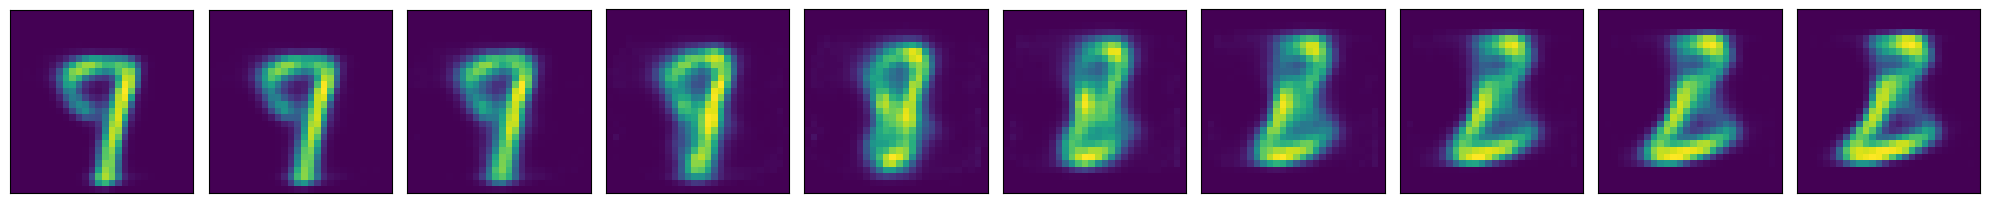

In [ ]:
with torch.no_grad():

    # model = VAE_decoder()

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = pca.inverse_transform(model_input) #Take it back to 20D
        model_input = torch.from_numpy(model_input).float()

#         print('model_input: {}'.format(model_input))

        out = model.decode(model_input.to(device))
        out = out.cpu().numpy()

        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

[2 5]
targets[:20]: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
latentVar[:20]: [[-0.42634115  1.6109705 ]
 [-0.49833652 -2.0148885 ]
 [-2.4858377  -0.01116236]
 [ 1.8376735  -0.8063359 ]
 [ 1.5565478   1.4621323 ]
 [-2.7655363   0.27460667]
 [ 0.0034253   1.4324632 ]
 [ 0.17337987  1.1331831 ]
 [ 1.3089815   0.50846654]
 [ 0.603113    0.91610974]
 [ 1.635922   -1.1382352 ]
 [ 0.98792    -0.8636446 ]
 [ 0.5503722   2.2806902 ]
 [ 2.0348463   0.02111262]
 [-2.6395104  -0.47506204]
 [-0.12491899 -0.40136597]
 [ 1.3101307   2.3314285 ]
 [ 0.28924376  1.4467072 ]
 [ 0.07145346 -0.1327919 ]
 [ 0.51605576  1.7441493 ]]
x0,y0: -2.485837697982788,-0.011162360198795795
x1,y1: -2.765536308288574,0.2746066749095917
xvals: [-2.4858377  -2.51691532 -2.54799294 -2.57907057 -2.61014819 -2.64122581
 -2.67230344 -2.70338106 -2.73445868 -2.76553631]
yvals: [-0.01116236  0.02058975  0.05234187  0.08409398  0.1158461   0.14759821
  0.17935033  0.21110244  0.24285456  0.27460667]


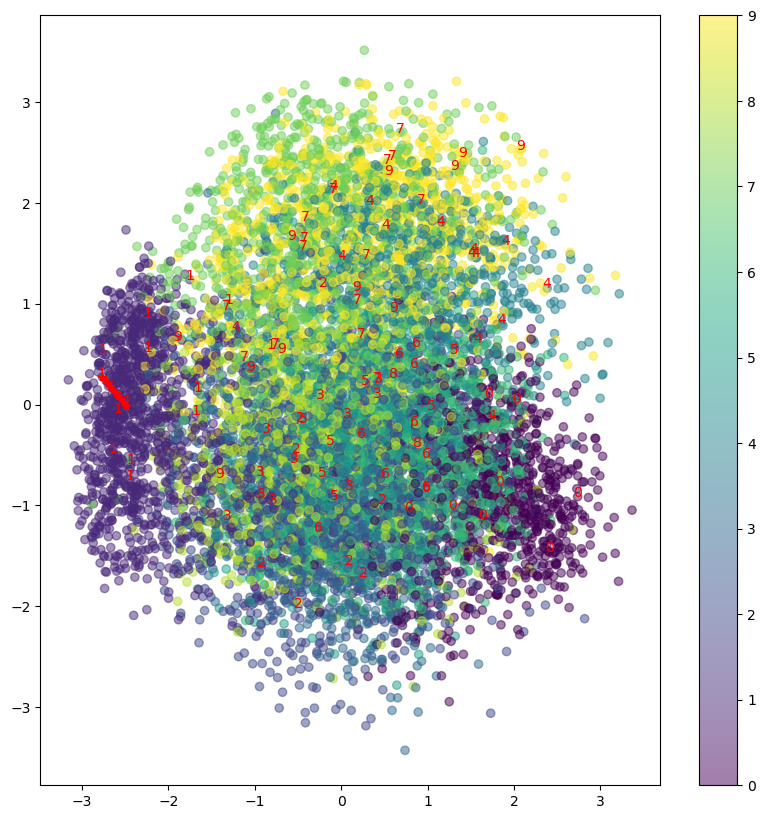

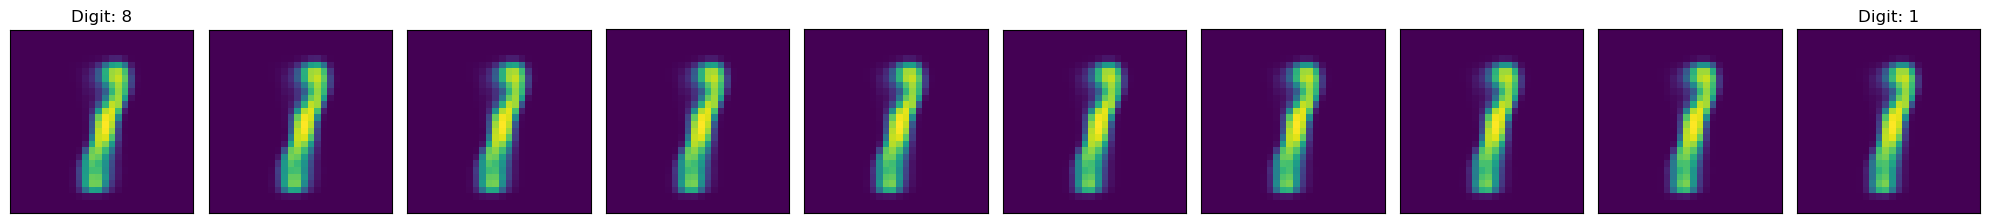

In [ ]:
# Redo for digits in the same class
with torch.no_grad():
    model.eval()
    data, targets = next(iter(large_batch))
    targets = targets.numpy()
    idx_ = np.where(targets==1)[0] # Get two '6'.
    print(idx_[:2])
    data = data.to(device)
    recon_batch, mu, logvar = model(data)

    #Reduce dimensions to 2D
    pca = PCA(n_components=2)
    latentVar = pca.fit_transform(mu.cpu().numpy())

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=100
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):
        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')

    # model = VAE_decoder()

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = pca.inverse_transform(model_input) #Take it back to 20D
        model_input = torch.from_numpy(model_input).float()

#         print('model_input: {}'.format(model_input))

        out = model.decode(model_input.to(device))
        out = out.cpu().numpy()

        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

ax[0].set_title('Digit: 8')
ax[9].set_title('Digit: 1')
fig.tight_layout()

## Question 3.1.1.
__How does the VAE's latent space compare to the latent space of your previous autoencoder?
Do the generated images have more clarity? Is this most noticeable between or within classes?__

## Question 3.1.2.
__In what situations would a VAE be more useful than a vanilla autoencoder, and when
would you prefer a vanilla autoencoder to a VAE?__


## Question 3.1.3.
__The distance between embeddings in your first autoencoder provided some measure of the
similarity between digits. To what extent is this preserved, or improved, by the VAE?__